# PHASE 1: Data Understanding & Validation

## Big-Tech-Grade User Retention & Churn Prediction System

---

**Author**: Senior Data Scientist  
**Date**: February 2026  
**Objective**: Load, validate, and understand the raw dataset before any transformations

---

## Table of Contents
1. [Setup & Data Loading](#1-setup--data-loading)
2. [Schema Inspection](#2-schema-inspection)
3. [Data Quality Assessment](#3-data-quality-assessment)
4. [Timestamp Validation](#4-timestamp-validation)
5. [Invalid Transaction Handling](#5-invalid-transaction-handling)
6. [Data Quality Report](#6-data-quality-report)

---

## 1. Setup & Data Loading

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print(" Libraries imported successfully")

 Libraries imported successfully


In [3]:
import os

PROJECT_ROOT = '/Users/anuj/Desktop/Churn_Retension/churn-prediction-bigtech'
RAW_DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'raw')
PROCESSED_DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'processed')

DATA_FILE = os.path.join(RAW_DATA_PATH, 'online_retail_II.csv')

if not os.path.exists(DATA_FILE):
    print(" Data file not found. Please download using kagglehub:")
    print("\nimport kagglehub")
    print("path = kagglehub.dataset_download('mashlyn/online-retail-ii-uci')")
    print("# Then copy the CSV to data/raw/")
else:
    print(f" Data file found at: {DATA_FILE}")

 Data file found at: /Users/anuj/Desktop/Churn_Retension/churn-prediction-bigtech/data/raw/online_retail_II.csv


In [4]:

print("Loading data... (this may take a moment)")

try:
    df_raw = pd.read_csv(DATA_FILE, encoding='utf-8')
    
    df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])
    
    print(f" Data loaded successfully!")
    print(f"   - Total rows: {len(df_raw):,}")
    print(f"   - Date range: {df_raw['InvoiceDate'].min()} to {df_raw['InvoiceDate'].max()}")
    
except FileNotFoundError:
    print(" Please download the data file first (see cell above)")
    raise

Loading data... (this may take a moment)
 Data loaded successfully!
   - Total rows: 1,067,371
   - Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00


---

## 2. Schema Inspection

In [5]:
print("=" * 60)
print("DATASET SCHEMA")
print("=" * 60)
df_raw.info()

DATASET SCHEMA
<class 'pandas.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  str           
 1   StockCode    1067371 non-null  str           
 2   Description  1062989 non-null  str           
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[us]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(1), str(4)
memory usage: 117.3 MB


In [6]:
column_descriptions = {
    'Invoice': 'Unique invoice number (starts with C for cancellations)',
    'StockCode': 'Product code (unique per item)',
    'Description': 'Product name/description',
    'Quantity': 'Number of items purchased (negative = return/cancellation)',
    'InvoiceDate': 'Date and time of transaction',
    'Price': 'Unit price in GBP',
    'Customer ID': 'Unique customer identifier (null for guest checkouts)',
    'Country': 'Customer country of residence'
}

print("\n" + "=" * 60)
print("COLUMN DESCRIPTIONS")
print("=" * 60)
for col, desc in column_descriptions.items():
    print(f"  {col:15} : {desc}")


COLUMN DESCRIPTIONS
  Invoice         : Unique invoice number (starts with C for cancellations)
  StockCode       : Product code (unique per item)
  Description     : Product name/description
  Quantity        : Number of items purchased (negative = return/cancellation)
  InvoiceDate     : Date and time of transaction
  Price           : Unit price in GBP
  Customer ID     : Unique customer identifier (null for guest checkouts)
  Country         : Customer country of residence


In [7]:
print("\n" + "=" * 60)
print("SAMPLE DATA (First 10 rows)")
print("=" * 60)
df_raw.head(10)


SAMPLE DATA (First 10 rows)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085.00,United Kingdom
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085.00,United Kingdom
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085.00,United Kingdom
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085.00,United Kingdom


In [8]:
print("\n" + "=" * 60)
print("DATA TYPES ANALYSIS")
print("=" * 60)

dtype_analysis = pd.DataFrame({
    'Column': df_raw.columns,
    'Current Type': df_raw.dtypes.values,
    'Expected Type': ['object', 'object', 'object', 'int64', 'datetime64', 'float64', 'float64', 'object'],
    'Needs Conversion': ['No', 'No', 'No', 'No', 'Check', 'No', 'YesInt', 'No']
})
print(dtype_analysis.to_string(index=False))


DATA TYPES ANALYSIS
     Column   Current Type Expected Type Needs Conversion
    Invoice            str        object               No
  StockCode            str        object               No
Description            str        object               No
   Quantity          int64         int64               No
InvoiceDate datetime64[us]    datetime64            Check
      Price        float64       float64               No
Customer ID        float64       float64          YesInt
    Country            str        object               No


---

## 3. Data Quality Assessment

In [9]:
print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

missing_df = pd.DataFrame({
    'Column': df_raw.columns,
    'Missing Count': df_raw.isnull().sum().values,
    'Missing %': (df_raw.isnull().sum() / len(df_raw) * 100).values,
    'Non-Missing': df_raw.notnull().sum().values
}).sort_values('Missing %', ascending=False)

print(missing_df.to_string(index=False))

MISSING VALUES ANALYSIS
     Column  Missing Count  Missing %  Non-Missing
Customer ID         243007      22.77       824364
Description           4382       0.41      1062989
    Invoice              0       0.00      1067371
  StockCode              0       0.00      1067371
   Quantity              0       0.00      1067371
InvoiceDate              0       0.00      1067371
      Price              0       0.00      1067371
    Country              0       0.00      1067371


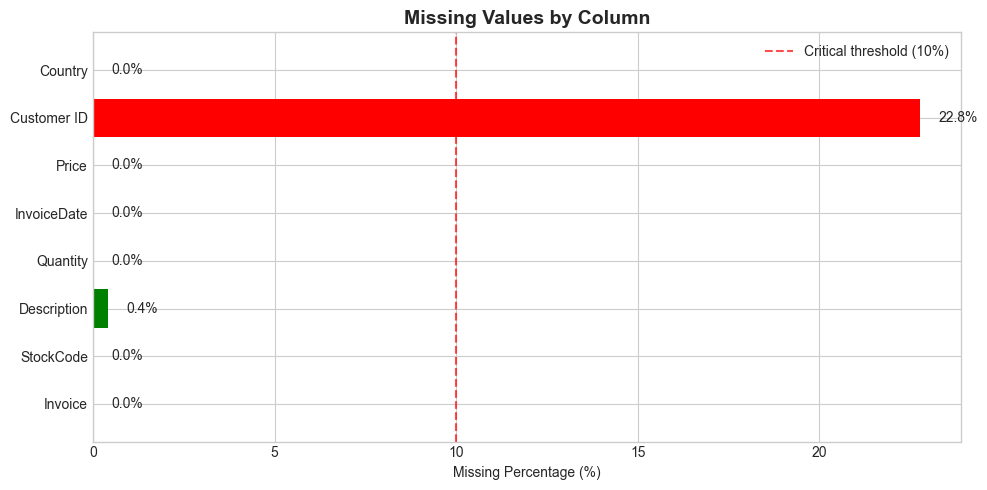


 KEY FINDING: Customer ID has significant missing values (guest checkouts)
    These rows MUST be excluded for churn analysis (no customer tracking)


In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

missing_pct = df_raw.isnull().sum() / len(df_raw) * 100
colors = ['red' if x > 10 else 'orange' if x > 1 else 'green' for x in missing_pct]

bars = ax.barh(missing_pct.index, missing_pct.values, color=colors)
ax.set_xlabel('Missing Percentage (%)')
ax.set_title('Missing Values by Column', fontsize=14, fontweight='bold')
ax.axvline(x=10, color='red', linestyle='--', alpha=0.7, label='Critical threshold (10%)')

for bar, val in zip(bars, missing_pct.values):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center')

plt.legend()
plt.tight_layout()
plt.show()

print("\n KEY FINDING: Customer ID has significant missing values (guest checkouts)")
print("    These rows MUST be excluded for churn analysis (no customer tracking)")

In [11]:
print("=" * 60)
print("UNIQUE VALUES ANALYSIS")
print("=" * 60)

unique_analysis = pd.DataFrame({
    'Column': df_raw.columns,
    'Unique Values': df_raw.nunique().values,
    'Cardinality %': (df_raw.nunique() / len(df_raw) * 100).values
})
print(unique_analysis.to_string(index=False))

print(f"\n Key Statistics:")
print(f"   - Unique Customers: {df_raw['Customer ID'].nunique():,}")
print(f"   - Unique Invoices: {df_raw['Invoice'].nunique():,}")
print(f"   - Unique Products: {df_raw['StockCode'].nunique():,}")
print(f"   - Countries: {df_raw['Country'].nunique():,}")

UNIQUE VALUES ANALYSIS
     Column  Unique Values  Cardinality %
    Invoice          53628           5.02
  StockCode           5305           0.50
Description           5698           0.53
   Quantity           1057           0.10
InvoiceDate          47635           4.46
      Price           2807           0.26
Customer ID           5942           0.56
    Country             43           0.00

 Key Statistics:
   - Unique Customers: 5,942
   - Unique Invoices: 53,628
   - Unique Products: 5,305
   - Countries: 43


In [12]:
print("=" * 60)
print("STATISTICAL SUMMARY (Numeric Columns)")
print("=" * 60)

df_raw[['Quantity', 'Price']].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])

STATISTICAL SUMMARY (Numeric Columns)


,Quantity,Price
count,1067371.00,1067371.00
mean,9.94,4.65
std,172.71,123.55
min,-80995.00,-53594.36
1%,-3.00,0.21
5%,1.00,0.42
25%,1.00,1.25
50%,3.00,2.10
75%,10.00,4.15
95%,30.00,9.95


---

## 4. Timestamp Validation

In [13]:
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])

print("=" * 60)
print("TIMESTAMP ANALYSIS")
print("=" * 60)

print(f"\nDate Range:")
print(f"   - Earliest: {df_raw['InvoiceDate'].min()}")
print(f"   - Latest:   {df_raw['InvoiceDate'].max()}")
print(f"   - Span:     {(df_raw['InvoiceDate'].max() - df_raw['InvoiceDate'].min()).days} days")

TIMESTAMP ANALYSIS

Date Range:
   - Earliest: 2009-12-01 07:45:00
   - Latest:   2011-12-09 12:50:00
   - Span:     738 days


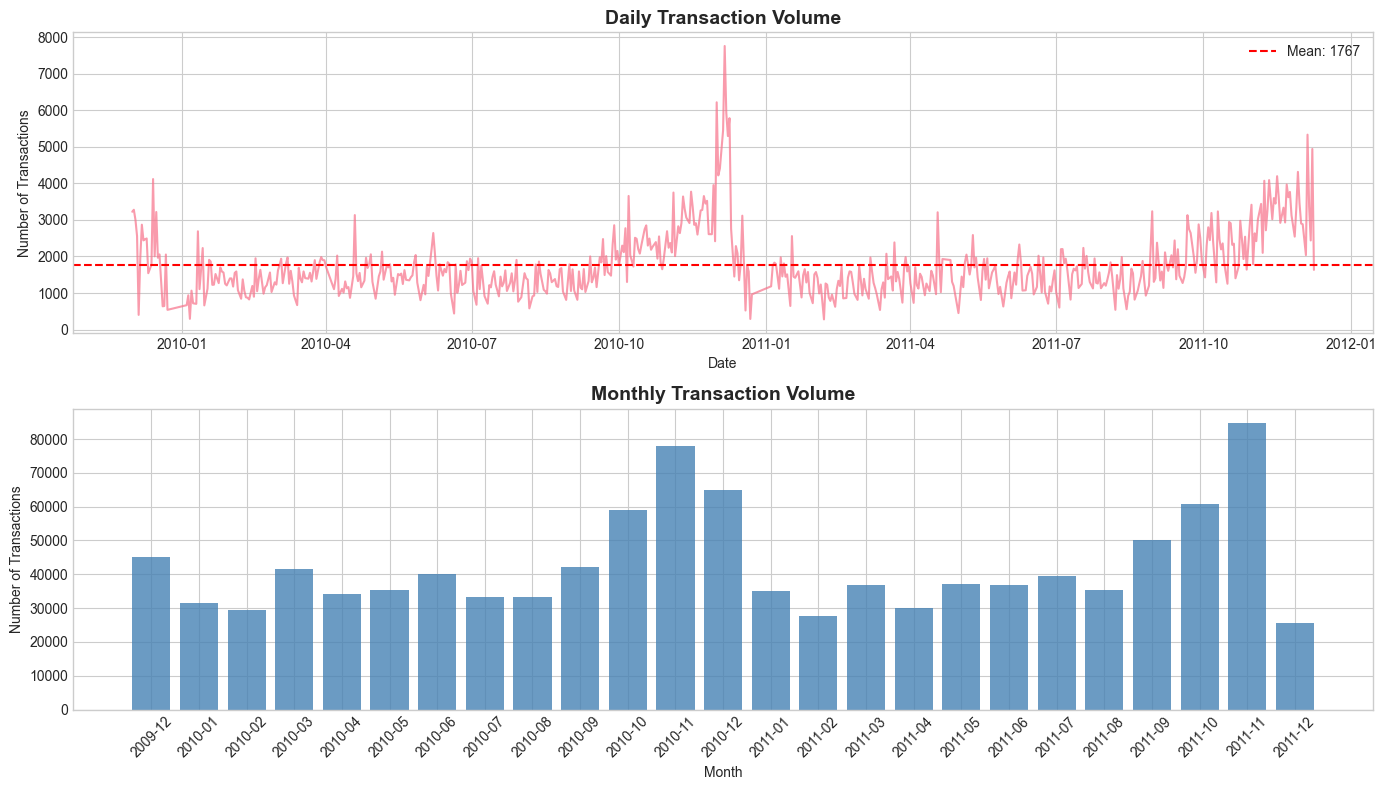


 Timestamp validation complete - no obvious gaps or anomalies


In [14]:
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

daily_txn = df_raw.groupby(df_raw['InvoiceDate'].dt.date).size()
axes[0].plot(daily_txn.index, daily_txn.values, alpha=0.7)
axes[0].set_title('Daily Transaction Volume', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Number of Transactions')
axes[0].axhline(y=daily_txn.mean(), color='red', linestyle='--', label=f'Mean: {daily_txn.mean():.0f}')
axes[0].legend()

monthly_txn = df_raw.groupby(df_raw['InvoiceDate'].dt.to_period('M')).size()
axes[1].bar(range(len(monthly_txn)), monthly_txn.values, color='steelblue', alpha=0.8)
axes[1].set_xticks(range(len(monthly_txn)))
axes[1].set_xticklabels([str(p) for p in monthly_txn.index], rotation=45)
axes[1].set_title('Monthly Transaction Volume', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

print("\n Timestamp validation complete - no obvious gaps or anomalies")

In [15]:
future_dates = df_raw[df_raw['InvoiceDate'] > pd.Timestamp('2011-12-31')]
print(f"\nFuture dates (>2011-12-31): {len(future_dates):,} rows")

old_dates = df_raw[df_raw['InvoiceDate'] < pd.Timestamp('2009-01-01')]
print(f"Old dates (<2009-01-01): {len(old_dates):,} rows")


Future dates (>2011-12-31): 0 rows
Old dates (<2009-01-01): 0 rows


---

## 5. Invalid Transaction Handling

In [16]:
print("=" * 60)
print("INVALID TRANSACTION ANALYSIS")
print("=" * 60)

cancellations = df_raw[df_raw['Invoice'].astype(str).str.startswith('C')]
print(f"\n1. Cancellations (Invoice starts with 'C'):")
print(f"   Count: {len(cancellations):,} ({len(cancellations)/len(df_raw)*100:.2f}%)")

negative_qty = df_raw[df_raw['Quantity'] < 0]
print(f"\n2. Negative Quantity:")
print(f"   Count: {len(negative_qty):,} ({len(negative_qty)/len(df_raw)*100:.2f}%)")

invalid_price = df_raw[df_raw['Price'] <= 0]
print(f"\n3. Zero or Negative Price:")
print(f"   Count: {len(invalid_price):,} ({len(invalid_price)/len(df_raw)*100:.2f}%)")

missing_customer = df_raw[df_raw['Customer ID'].isna()]
print(f"\n4. Missing Customer ID:")
print(f"   Count: {len(missing_customer):,} ({len(missing_customer)/len(df_raw)*100:.2f}%)")

INVALID TRANSACTION ANALYSIS

1. Cancellations (Invoice starts with 'C'):
   Count: 19,494 (1.83%)

2. Negative Quantity:
   Count: 22,950 (2.15%)

3. Zero or Negative Price:
   Count: 6,207 (0.58%)

4. Missing Customer ID:
   Count: 243,007 (22.77%)


In [17]:
print("=" * 60)
print("CANCELLATION vs NEGATIVE QUANTITY OVERLAP")
print("=" * 60)

cancel_and_negative = df_raw[
    (df_raw['Invoice'].astype(str).str.startswith('C')) & 
    (df_raw['Quantity'] < 0)
]
print(f"\nRows that are BOTH cancellation AND negative qty: {len(cancel_and_negative):,}")
print(f"   - % of cancellations: {len(cancel_and_negative)/len(cancellations)*100:.1f}%")
print(f"   - % of negative qty: {len(cancel_and_negative)/len(negative_qty)*100:.1f}%")

print("\n INSIGHT: Most cancellations have negative quantities (returns)")

CANCELLATION vs NEGATIVE QUANTITY OVERLAP

Rows that are BOTH cancellation AND negative qty: 19,493
   - % of cancellations: 100.0%
   - % of negative qty: 84.9%

 INSIGHT: Most cancellations have negative quantities (returns)


In [18]:
print("=" * 60)
print("SPECIAL STOCK CODES ANALYSIS")
print("=" * 60)

special_codes = df_raw[~df_raw['StockCode'].astype(str).str.match(r'^\d+[A-Za-z]?$')]
special_code_counts = special_codes['StockCode'].value_counts().head(20)

print(f"\nTop 20 Special Stock Codes:")
print(special_code_counts.to_string())

print(f"\n Total special code transactions: {len(special_codes):,} ({len(special_codes)/len(df_raw)*100:.2f}%)")

SPECIAL STOCK CODES ANALYSIS

Top 20 Special Stock Codes:
StockCode
POST            2122
DOT             1446
M               1421
15056BL          923
C2               282
79323LP          232
D                177
79323GR          123
S                104
BANK CHARGES     102
15056bl           93
ADJUST            67
AMAZONFEE         43
DCGS0058          31
gift_0001_20      29
gift_0001_30      29
DCGSSGIRL         25
DCGSSBOY          23
PADS              19
gift_0001_10      16

 Total special code transactions: 7,466 (0.70%)


In [19]:
print("=" * 60)
print("DATA CLEANING DECISIONS")
print("=" * 60)

cleaning_decisions = """
¬¬
 Issue                    Action        Rationale                                  
¼¼
 Missing Customer ID      REMOVE        Cannot track behavior for churn analysis   
 Cancellations (C*)       REMOVE        Not true purchases, distort behavior       
 Negative Quantity        REMOVE        Returns/adjustments, not purchases         
 Zero/Negative Price      REMOVE        Invalid transactions (gifts, adjustments)  
 Special Stock Codes      KEEP*         May represent legitimate purchases         
 Non-UK Countries         KEEP          Valid customers, global business           
´´

*Exception: Remove POST, D, M, BANK CHARGES, etc. (service codes, not products)
"""
print(cleaning_decisions)

DATA CLEANING DECISIONS

¬¬
 Issue                    Action        Rationale                                  
¼¼
 Missing Customer ID      REMOVE        Cannot track behavior for churn analysis   
 Cancellations (C*)       REMOVE        Not true purchases, distort behavior       
 Negative Quantity        REMOVE        Returns/adjustments, not purchases         
 Zero/Negative Price      REMOVE        Invalid transactions (gifts, adjustments)  
 Special Stock Codes      KEEP*         May represent legitimate purchases         
 Non-UK Countries         KEEP          Valid customers, global business           
´´

*Exception: Remove POST, D, M, BANK CHARGES, etc. (service codes, not products)



In [20]:
print("=" * 60)
print("APPLYING DATA CLEANING")
print("=" * 60)

initial_rows = len(df_raw)

df_clean = df_raw.copy()

df_clean = df_clean[df_clean['Customer ID'].notna()]
print(f"After removing missing Customer ID: {len(df_clean):,} rows (removed {initial_rows - len(df_clean):,})")

rows_before = len(df_clean)
df_clean = df_clean[~df_clean['Invoice'].astype(str).str.startswith('C')]
print(f"After removing cancellations: {len(df_clean):,} rows (removed {rows_before - len(df_clean):,})")

rows_before = len(df_clean)
df_clean = df_clean[df_clean['Quantity'] > 0]
print(f"After removing negative quantities: {len(df_clean):,} rows (removed {rows_before - len(df_clean):,})")

rows_before = len(df_clean)
df_clean = df_clean[df_clean['Price'] > 0]
print(f"After removing invalid prices: {len(df_clean):,} rows (removed {rows_before - len(df_clean):,})")

service_codes = ['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK', 'C2', 'AMAZONFEE']
rows_before = len(df_clean)
df_clean = df_clean[~df_clean['StockCode'].isin(service_codes)]
print(f"After removing service codes: {len(df_clean):,} rows (removed {rows_before - len(df_clean):,})")

df_clean['Customer ID'] = df_clean['Customer ID'].astype(int)

print(f"\n" + "="*60)
print(f"CLEANING SUMMARY")
print(f"="*60)
print(f"Original rows:  {initial_rows:,}")
print(f"Clean rows:     {len(df_clean):,}")
print(f"Rows removed:   {initial_rows - len(df_clean):,} ({(initial_rows - len(df_clean))/initial_rows*100:.1f}%)")
print(f"\nUnique customers retained: {df_clean['Customer ID'].nunique():,}")

APPLYING DATA CLEANING
After removing missing Customer ID: 824,364 rows (removed 243,007)
After removing cancellations: 805,620 rows (removed 18,744)
After removing negative quantities: 805,620 rows (removed 0)
After removing invalid prices: 805,549 rows (removed 71)
After removing service codes: 802,679 rows (removed 2,870)

CLEANING SUMMARY
Original rows:  1,067,371
Clean rows:     802,679
Rows removed:   264,692 (24.8%)

Unique customers retained: 5,861


---

## 6. Data Quality Report

In [21]:
print("=" * 70)
print("            DATA QUALITY REPORT - CLEANED DATASET")
print("=" * 70)

print(f"""

                        DATASET OVERVIEW                              
£
  Total Transactions:     {len(df_clean):>10,}                               
  Unique Customers:       {df_clean['Customer ID'].nunique():>10,}                               
  Unique Products:        {df_clean['StockCode'].nunique():>10,}                               
  Unique Invoices:        {df_clean['Invoice'].nunique():>10,}                               
  Countries:              {df_clean['Country'].nunique():>10,}                               
£
                        TIME PERIOD                                   
£
  Start Date:             {str(df_clean['InvoiceDate'].min().date()):>10}                               
  End Date:               {str(df_clean['InvoiceDate'].max().date()):>10}                               
  Duration:               {(df_clean['InvoiceDate'].max() - df_clean['InvoiceDate'].min()).days:>10} days                           
£
                        DATA QUALITY                                  
£
  Missing Values:         {df_clean.isnull().sum().sum():>10,}                               
  Duplicate Rows:         {df_clean.duplicated().sum():>10,}                               

""")

            DATA QUALITY REPORT - CLEANED DATASET


                        DATASET OVERVIEW                              
£
  Total Transactions:        802,679                               
  Unique Customers:            5,861                               
  Unique Products:             4,624                               
  Unique Invoices:            36,639                               
  Countries:                      41                               
£
                        TIME PERIOD                                   


In [22]:
print("=" * 60)
print(" KEY RISKS & CONSIDERATIONS")
print("=" * 60)

risks = """
1. SURVIVORSHIP BIAS
   - We only see customers who made at least one purchase
   - Cannot model acquisition  first purchase churn
   - Mitigation: Focus on repeat purchase behavior

2. DATA RECENCY
   - Data ends in December 2011
   - Business patterns may have changed
   - Mitigation: Focus on timeless behavioral features

3. CHANNEL LIMITATION
   - Online-only transactions
   - No omnichannel view of customer
   - Mitigation: Acknowledge in model limitations

4. B2B CONTAMINATION
   - Some customers may be wholesalers/businesses
   - Different churn patterns than B2C
   - Mitigation: Filter extreme quantity orders if needed

5. SEASONAL EFFECTS
   - Strong holiday seasonality expected
   - May create false churn signals in Q1
   - Mitigation: Use seasonality-aware features
"""
print(risks)

 KEY RISKS & CONSIDERATIONS

1. SURVIVORSHIP BIAS
   - We only see customers who made at least one purchase
   - Cannot model acquisition  first purchase churn
   - Mitigation: Focus on repeat purchase behavior

2. DATA RECENCY
   - Data ends in December 2011
   - Business patterns may have changed
   - Mitigation: Focus on timeless behavioral features

3. CHANNEL LIMITATION
   - Online-only transactions
   - No omnichannel view of customer
   - Mitigation: Acknowledge in model limitations

4. B2B CONTAMINATION
   - Some customers may be wholesalers/businesses
   - Different churn patterns than B2C
   - Mitigation: Filter extreme quantity orders if needed

5. SEASONAL EFFECTS
   - Strong holiday seasonality expected
   - May create false churn signals in Q1
   - Mitigation: Use seasonality-aware features



In [23]:
output_path = os.path.join(PROCESSED_DATA_PATH, 'transactions_clean.parquet')
df_clean.to_parquet(output_path, index=False)
print(f"\n Cleaned dataset saved to: {output_path}")
print(f"   File size: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")


 Cleaned dataset saved to: /Users/anuj/Desktop/Churn_Retension/churn-prediction-bigtech/data/processed/transactions_clean.parquet
   File size: 4.96 MB


In [24]:
df_verify = pd.read_parquet(output_path)
print(f"\n Verification: Loaded {len(df_verify):,} rows from saved file")
assert len(df_verify) == len(df_clean), "Data integrity check failed!"
print("   Data integrity check: PASSED")


 Verification: Loaded 802,679 rows from saved file
   Data integrity check: PASSED


---

## Phase 1 Checklist

- [x] Loaded raw dataset (both sheets)
- [x] Inspected schema and data types
- [x] Validated timestamps (no anomalies)
- [x] Analyzed missing values (Customer ID is critical)
- [x] Identified invalid transactions (cancellations, negatives, service codes)
- [x] Applied cleaning rules with justification
- [x] Created data quality report
- [x] Documented key risks
- [x] Saved clean dataset for next phase

**Phase 1 Status: COMPLETE** 

---

**Next**: Phase 2 - SQL-First Exploratory Data Analysis